## Understading how to work with sound

### Credits :-
### Ricky Kim , Coding Ninjas and Towads Data Science
#### https://towardsdatascience.com/urban-sound-classification-part-2-sample-rate-conversion-librosa-ba7bc88f209a

In [1]:
from pip._internal import main
main(["install","librosa"])
#main(["install","pySoundFile"])

0

### Importing Important Library

In [2]:
import os
import struct
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
from scipy.signal import chirp
import soundfile as sf

### Getting  Metadata

In [3]:
data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
print(data.shape)

(8732, 8)


In [4]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,jackhammer,children_playing,drilling,air_conditioner,street_music,dog_bark,engine_idling,siren,car_horn,gun_shot
0,fold1,120,100,100,100,100,100,96,86,36,35
1,fold2,120,100,100,100,100,100,100,91,42,35
2,fold3,120,100,100,100,100,100,107,119,43,36
3,fold4,120,100,100,100,100,100,107,166,59,38
4,fold5,120,100,100,100,100,100,107,71,98,40
5,fold6,68,100,100,100,100,100,107,74,28,46
6,fold7,76,100,100,100,100,100,106,77,28,51
7,fold8,78,100,100,100,100,100,88,80,30,30
8,fold9,82,100,100,100,100,100,89,82,32,31
9,fold10,96,100,100,100,100,100,93,83,33,32


In [6]:
print(data['class'].value_counts(normalize=True))

air_conditioner     0.114521
jackhammer          0.114521
children_playing    0.114521
engine_idling       0.114521
street_music        0.114521
dog_bark            0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64


### Plotting wave



In [7]:
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

In [8]:
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


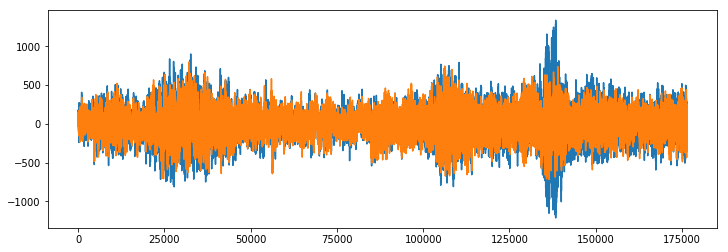

In [9]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

In [12]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [14]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
print(data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  n_channels  sampling_rate  bit_depth  
0          dog_bark           2          44100         16  
1  children_playing           2          44100         16  
2  children_playing           2          44100         16  
3  children_playing           2          44100         16  
4  children_playing           2          44100         16  


In [15]:
print(data.n_channels.value_counts(),end = "\n\n\n")
print(data.bit_depth.value_counts())

2    7993
1     739
Name: n_channels, dtype: int64


16    5758
24    2753
32     169
8       43
4        9
Name: bit_depth, dtype: int64


## Nyquist Sampling Theorem Example ############

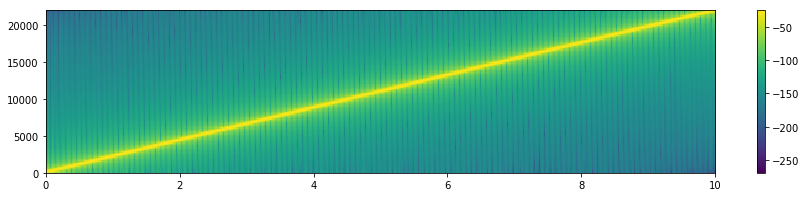

In [16]:
fs = 44100
T = 10
t = np.linspace(0, T, T*fs, endpoint=False)

w = chirp(t, f0=20, f1=22050, t1=T, method='linear')
sf.write('sine_sweep_44100.wav', w, fs)

plt.figure(figsize=(15,3))
plt.specgram(w, Fs=44100)
plt.colorbar()
_=plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_44100.wav')

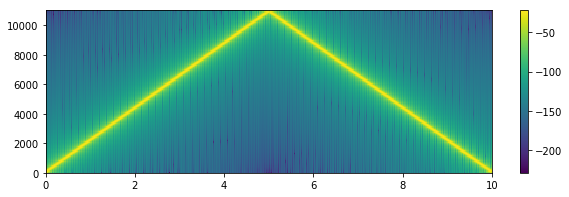

In [17]:
down_sampled = w[::2]
sf.write('sine_sweep_downsampled.wav', down_sampled, 22050)

plt.figure(figsize=(10,3))
plt.specgram(down_sampled, Fs=22050)
plt.colorbar()
_=plt.axis((0,10,0,11050))
ipd.Audio('sine_sweep_downsampled.wav')

###### END of Example
###     
###  
##### Why Librosa is better than scipy

In [18]:
data[data.slice_file_name == '100652-3-0-1.wav']

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
15,100652-3-0-1.wav,100652,0.5,4.5,1,2,3,dog_bark,2,44100,16


In [19]:
fullpath,_ = path_class('100652-3-0-1.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
scipy_sampling_rate, scipy_load = wav.read(fullpath)
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate,end = "\n\n")
print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))

original sample rate: 44100
converted sample rate: 22050

original wav file min~max range: -30926 ~ 30119
converted wav file min~max range: -0.7296108 ~ 0.74331266


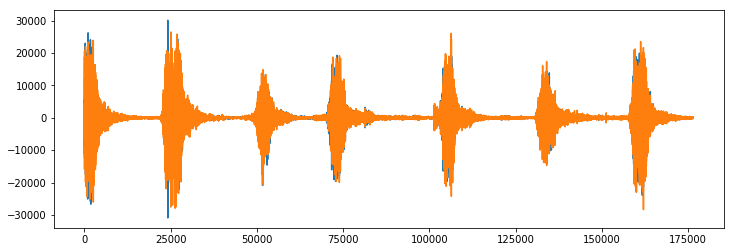

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_load)

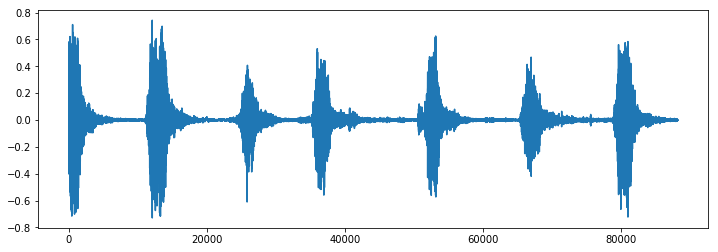

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(librosa_load)

### Advantages of Librosa
### Mono channel , sample sampling rate 22.05KHz

In [22]:
librosa_sampling_rate

22050

### This is the data sample

In [23]:
librosa_load

array([-0.05459652, -0.00335693,  0.06563966, ..., -0.00033616,
       -0.00177475, -0.00191076], dtype=float32)